In [1]:
from  __future__ import division
%pylab inline
import numpy as np
from random import random


Populating the interactive namespace from numpy and matplotlib


En este notebook se implenta el algoritomo Metropolis–Hastings, el método MCMC más sencillo. Y se  usa para  determinar el factor de Hubble $H_0$ y la densidad de Materia $\Omega_m$, usando datos de distancias de supernovas. 



La distancia-modulo, para una supernova se estima a partir de su magnitud (relacionada con el flujo de luz) a traves de : 
$\mu=25-5Log_{10}(H_0/100)+5Log_{10}(D_L/Mpc)$

donde $D_L$ es la distancia luminossa. 

La expresión para el  calculo de la distancia luminosa en el modelo LCDM es: 

$D_{L}=\frac{(1+z) c}{H_0 \sqrt{|1-\Omega |}} S_{k}(r)$,
donde, 

$r(z)= \sqrt{|1-\Omega |} \int_{0}^{z}{\frac{dz'}{\sqrt{\Omega_m (1+z')^3+\Omega_\Lambda+(1-\Omega)(1+z')^2}}} {\rm Mpc}$

donde $S_{k}(r)=\sin(r),r,sinh(r)$, dependiendo de si $\Omega\equiv \Omega_m+\Omega_\Lambda$ es $>1,=1,<1$, y $z$ es el redshift. 
 
 
La distancia en un Universo plano, $\Omega_T=1$,puede aproximarse mediante la siguiente expresión:  

$D_L= \frac{c}{H_0}(1+z)[\eta(1,\Omega_m)-\eta(1/(1+z),\Omega_m)]$

$\eta(a,\Omega_m)=2\sqrt{s^3+1}[a^{-4}-0.1540 s\,a^{-3}+0.4304 s^2\, a^{-2}+0.19097 s^3 a^{-1}+0.066941 s^4]^{-1/8}$

$s^3=(1-\Omega_m)/\Omega_m$

La que resulta de un ajuste a la solución numérica completa de la expresión:
$D_L= 3000 h^{-1}(1+z) \int_{0}^{z}{\frac{dz'}{\sqrt{\Omega_m (1+z')^3+1-\Omega_m}}} {\rm Mpc}$

donde $H_0=100h\,\rm{ km s^{-1} Mpc^{-1}}$

Referencias:
https://drive.google.com/file/d/0B7rKkdILAWiRWGxtU2taMXJNS0k/view

http://astro.ic.ac.uk/sites/default/files/ICIC%20Data%20Analysis%20lectures.pdf

In [2]:
data=np.loadtxt('data_SN')
cov_mat=np.loadtxt('covmatrix.txt').T
cov_mat=np.reshape(cov_mat,(-1,31))
invcov=np.linalg.inv(cov_mat)



In [3]:
c=3e5
def eta(a,Om):
        s3=(1.-Om)/Om
        s2=s3**(2./3)
        s=s3**(1./3)
        return 2.*np.sqrt(s3+1.)*((1./a**4)-(0.1540*s/a**3)+(0.4304*s2/a**2)+(0.19097*s3/a)+(0.066941*s**4))**(-1./8.)
    
def DL(z,H0,Om):
    return c/H0*(1.+z)*(eta(1.,Om)-eta(1./(1.+z),Om))

def mu(z,H0,Om):
    t=25.-5.*np.log10(H0/100.)+5.*np.log10(DL(z,H0,Om))
    return t

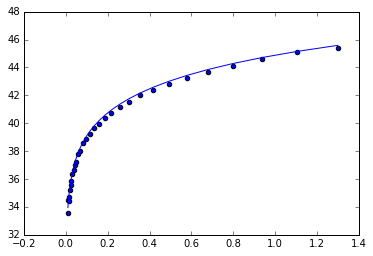

In [4]:
plot(data[0],mu(data[0],70,0.3))
scatter(data[0],data[1])

In [5]:
def lnprior(theta):
    if ((1.<theta[0]<100.) and (0.01<theta[1]<1.0)):
        return 0.
    else:
        return -np.infty
    return
    
def lnlike(theta):
    model=mu(data[0],theta[0],theta[1])
    diff=data[1]-model
    tmp=0.
    tmp=np.dot(diff,invcov)
    tmp=np.dot(tmp,diff.T)
    tmp=-0.5*np.sum(tmp)
    return tmp

def MCMC_step(theta_start,theta_trial):
    if (lnprior(theta_trial)):
        return theta_start    
    p_start=lnlike(theta_start)
    p_trial=lnlike(theta_trial)
    p_acc=np.exp(p_trial-p_start)
    p_acc=min(1.,p_acc)
    if (p_acc==1.):
        return theta_trial
    else:
        x=random()
        if (p_acc>=x):
            return theta_trial
        else:
            return theta_start
    return 
    

In [6]:
Nsamples=1000
sigma1=1
sigma2=0.1


Nchains=10
theta_start=[50.,0.3]
chains=[]
for j in range(Nchains):
    theta_start=np.array([np.random.normal(theta_start[0],sigma1),np.random.normal(theta_start[1], sigma2)])
    for i in range(Nsamples):
        if i==0:
            chain=theta_start
        else:
            theta_trial=np.array([np.random.normal(theta_start[0], sigma1),np.random.normal(theta_start[1], sigma2)])
            theta_new=MCMC_step(theta_start,theta_trial)
            chain=np.concatenate((chain,theta_new))
            theta_start=theta_new
    if j==0:
        chains=chain
    else:
        chains=np.vstack((chains,chain))

In [7]:
chain_=chains[:,:].reshape((-1, 2))
print len(chain_)

10000


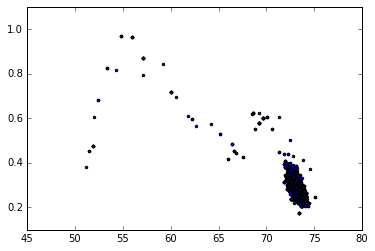

In [8]:
scatter(chain_[:,0],chain_[:,1],s=6)

(0.1, 0.5)

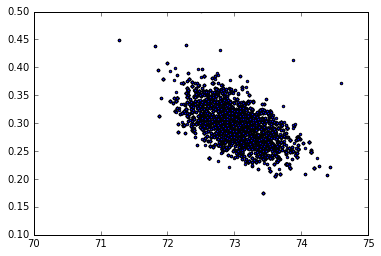

In [11]:
scatter(chain_[:,0],chain_[:,1],s=6)
xlim(70,75)
ylim(0.1,0.5)

(70, 75)

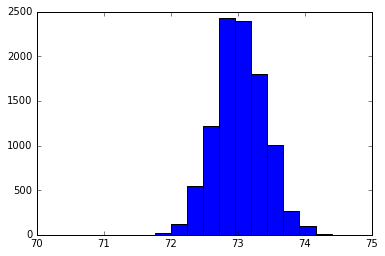

In [17]:
hist(chain_[:,0],bins=100)
xlim(70,75)

(0.1, 0.5)

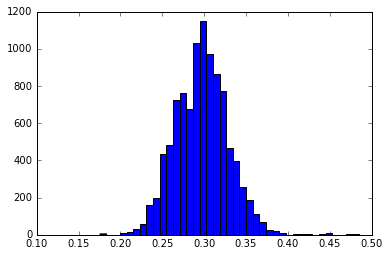

In [18]:
hist(chain_[:,1],bins=100)
xlim(0.1,0.5)

Ejercicios: 

a) Encuentra el valor promedio y la desviación estándar para cada uno de los parámetros. Haz un histograma-1D, de cada uno de los parámetros.

b) Explora el efecto de la variacion de los parametrso $\sigma_1$ y $\sigma_2$. Calcula la fracción de aceptación (Numero de propuestas aceptadas/Numero de propuestas totales), y gráficalo como función del parámetro $\sigma_1$, y $\sigma_2$. 

c)Explora el efecto de burning, cuantos pasos puedo/debo eliminar de la cadena completa. Investiga sobre los diferentes tests de convergencia.

d) Generaliza el método a generar varias cadenas que empiecen en puntos iniciales diferentes, al final juunta todas las cadenas en una sola y repite los analisis anteriores. 

e) Una vez que hayas ganado confinza en el método, implementa la expresion general para el calculo de distancias, y explora si el universo es abierto, plano, o cerrado, de acuerdo con estos datos.  